In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

!pip install umap-learn
import umap

!pip install --upgrade tensorflow
!pip install tensorflow-hub
import tensorflow as tf
tf.executing_eagerly()
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
embed = hub.load(module_url)

Requirement already up-to-date: tensorflow in c:\users\mrric\anaconda3\lib\site-packages (2.3.0)


In [3]:
message_analytics = pd.read_csv("../data/message_analytics.csv")
faq_feedback = pd.read_csv("../data/faq_feedback.csv")

print(message_analytics.head)
print(faq_feedback.head)

<bound method NDFrame.head of                  ts_in_db                   timestamp  bot_id  \
0     2020-07-27 11:13:42  2020-07-27T11:13:42.605955    1053   
1     2020-07-27 11:13:33  2020-07-27T11:13:33.504596    1053   
2     2020-07-27 11:12:14  2020-07-27T11:12:14.141874    1053   
3     2020-07-27 04:33:43  2020-07-27T04:33:43.009189    1053   
4     2020-07-27 04:32:27  2020-07-27T04:32:27.646525    1053   
...                   ...                         ...     ...   
2126  2020-02-17 19:25:52  2020-02-17T19:25:52.398509    1020   
2127  2020-02-17 19:25:38  2020-02-17T19:25:38.280107    1020   
2128  2020-02-17 19:25:27  2020-02-17T19:25:27.705199    1020   
2129  2020-02-17 19:25:12  2020-02-17T19:25:12.681883    1020   
2130  2020-02-17 19:25:01  2020-02-17T19:25:01.045462    1020   

      conversation_id                                         top_intent  \
0                1174          faq:proyecto_de_análisis_de_fugas_de_aire   
1                1174          faq:pr

# Getting text that trigger "something else" responses

In [25]:
# Get rows where "something else" button is triggered
something_else = message_analytics[message_analytics['top_intent']=='navigational:something_else']

# Get rows that triggered a "something else" response
idx_prev = something_else.index - 1
something_else_triggers = message_analytics.iloc[idx_prev,:]
# print(something_else_triggers)

# Get text from "something else" reponses
novel = something_else_triggers['user_event'].map(eval)
novel = novel.apply(pd.Series)

top_intents = something_else_triggers['top_intent']
# print(top_intents)

print(novel['top_intent'][26]['confidence'])

res = [sub['confidence'] for sub in novel['top_intent']]
print(res)

0.0024419102838010268
['0.0024419102838010268', '0.007944867865861684', '1', '1', '1', '0.6472493112141545', '1', '0.46362792155631927', '0.4308645333051585', '0.8214871418507642', '1', '1', '1', '0.675809773781817', '0.6427997231114075', '0.6236009707725567', '0.07937196835755458', '0.9916824204456386', '0.9806840241231486', '0.6504177236002661', '0.9879033875482026', '0.6135620477460777', '0.42746690212649013', '0.6630187061563448', '1', '0.9926111428162298', '0.33737529289438734', '0.7868397888515258', '0.7717739368733029', '0.7805467259859522', '0.7570452616079483', '0.2610325234354801', '0.9608682444152882', '0.7126643183879443', '0.7126974408660177', '0.7543986382427695', '1', '0.9827187487885621', '0.6583779733226753', '0.5996444152783914']


# Preprocess upvote/downvote chatbot feedback

In [54]:
pos_feedback = faq_feedback[faq_feedback['correct'] == 1]
neg_feedback = faq_feedback[faq_feedback['correct'] == -1]

# Confirm that these are at the "center" of clusters
print(pos_feedback[['utterance', 'correct']])

# Confirm that these are at "boundaries" of clusters
# -- add to novelty detection pipeline
print(neg_feedback[['utterance', 'correct']])

                                        utterance  correct
0                      where can i have some food        1
1                      where can i have some food        1
2                                        我可以去哪里游泳        1
3                                        我可以去哪里游泳        1
6          i want to move liras from turkey to uk        1
7          i want to move liras from turkey to uk        1
8   i would to send pounds from england to serbia        1
9   i would to send pounds from england to serbia        1
10                  quiero mover dólares a libras        1
11      How fast can new training be implemented?        1
12      How fast can new training be implemented?        1
13                      I want to move to Canada?        1
14                      I want to move to Canada?        1
15              How do I move money to Hong Kong?        1
17    i want to book an appointement with revolut        1
21                                 pricing errors       

In [65]:
vectors = pd.read_csv("data/extracted_n26_tsv_vecs.tsv", delimiter='\t|,', header=None, engine='python')
vectors = vectors.drop(vectors.columns[0], axis=1)
metadata = pd.read_csv("data/extracted_n26_tsv_metadata.tsv", delimiter='\t')

vec_meta = vectors.join(metadata)
train = vec_meta[vec_meta['FAQ_id'] <= 140] # only train on first 130 classes
train = train.drop(['FAQ_id', 'locale', 'market', 'question'], axis=1)

frames = [text['text'], neg_feedback['utterance']]
novel_df = pd.concat(frames).reset_index(drop=True)
print(novel_df)

print("Embedding novel text...")
novel = embed(novel_df)
novel_vec_df = pd.DataFrame(novel)
novel_vec_df.to_pickle('data/novel.pkl')

0                                      Contact an agent
1                          i want to book an appiontent
2                       navigational:connect_with_agent
3                  Are CretanLuxuryVillas sustainable? 
4                           i want to send money abroad
5                        i want to send money to france
6                            wnbat to see twhat tending
7                       navigational:connect_with_agent
8                     how much i a peer to peer tranfer
9                              when will i get my money
10           can i make a payment in dubai with my card
11                                    what time in USA?
12                               connect me to an agent
13                                      i like you man!
14                           do you offer a credit card
15                                                  hey
16                       i have issues withrawing money
17                                     How do I 

In [72]:
def reduce(dataframe, reducer='umap', n_comp=50):
    if reducer == 'pca':
        reducer = PCA(n_components=n_comp)
    elif reducer == 'svd':
        reducer = TruncatedSVD(n_components=n_comp)
    else:
        reducer = umap.UMAP(n_components=n_comp)
    scaled_data = StandardScaler().fit_transform(dataframe)
    embedding = reducer.fit_transform(scaled_data)
    embedding = pd.DataFrame(embedding)
    return embedding, reducer

# X_train, reducer = reduce(train, reducer='pca', n_comp=200)
# X_novel, reducer = reduce(novel, reducer='pca', n_comp=200)

X_train = train
X_novel = novel

In [75]:
def lof(train_data, test_data):
    clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination='auto')
    clf.fit(train_data)
    y_train_scores = clf.negative_outlier_factor_
    
#     y_pred_test = clf.predict(test_data)
    y_test_scores = clf.score_samples(test_data)  # outlier scores
    y_test_scores = pd.Series(y_test_scores)
    return test_data, y_train_scores, y_test_scores

X_test, y_train_scores, y_test_scores = lof(X_train, X_novel)

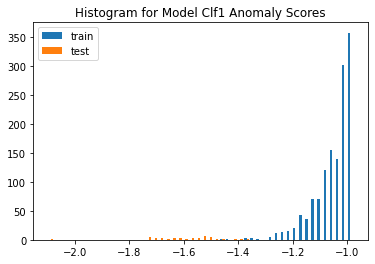

In [78]:
# Plot it!
plt.hist([y_train_scores, y_test_scores], bins=50, label=['train','test'])
plt.legend(prop={'size': 10})
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()